# Data Exploration of Physical Therapy Dataset

## Imports + Data

In [74]:
import os
import math
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/physical-therapy-exercises-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1


Collecting metadata for template times and subject/exercise/sensor information to use for later

In [34]:
times = []
data = []

for subject in os.listdir(path):
    subject_path = os.path.join(path, subject)
    if not os.path.isdir(subject_path):
        continue  # skip non-folder items
    
    for exercise in os.listdir(subject_path):
        exercise_path = os.path.join(subject_path, exercise)
        if not os.path.isdir(exercise_path):
            continue

        # CASE A: .txt files directly inside exercise folder
        for f in os.listdir(exercise_path):
            file_path = os.path.join(exercise_path, f)
            if os.path.isfile(file_path) and f.endswith(".txt"):
                times.append({
                    "subject": subject,
                    "exercise": exercise,
                    "file_name": f,
                    "path": file_path
                })

        # CASE B: nested sensor folders inside exercise folder
        for sensor in os.listdir(exercise_path):
            sensor_path = os.path.join(exercise_path, sensor)
            if os.path.isdir(sensor_path):
                for f in os.listdir(sensor_path):
                    file_path = os.path.join(sensor_path, f)
                    if f.endswith(".txt"):
                        data.append({
                            "subject": subject,
                            "exercise": exercise,
                            "sensor": sensor,
                            "file_name": f,
                            "path": file_path
                        })


template_times = pd.DataFrame(times)
df = pd.DataFrame(data)
df = df.sort_values(by=['subject', 'exercise', 'sensor']).reset_index().drop("index", axis=1)
df

,subject,exercise,sensor,file_name,path
0,s1,e1,u1,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e1,u1,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e1,u2,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e1,u2,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e1,u3,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
...,...,...,...,...,...
395,s5,e8,u3,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
396,s5,e8,u4,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
397,s5,e8,u4,test.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
398,s5,e8,u5,template_session.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


In [66]:
times_sorted = template_times.sort_values(by=['subject', 'exercise']).reset_index().drop('index', axis=1)
times_sorted.head()

,subject,exercise,file_name,path
0,s1,e1,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
1,s1,e2,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
2,s1,e3,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
3,s1,e4,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...
4,s1,e5,template_times.txt,/Users/hammy/.cache/kagglehub/datasets/rabieel...


## Single Data Point Exploration

Here I'm exploring the data of Subject 1, Exercise 1, Sensor 1

You can use this pathname to see what each data point would look like

In [68]:
sample_data = df.iloc[0].path
sample_time = times_sorted.iloc[0].path
sample_data, sample_time

('/Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1/s1/e1/u1/template_session.txt',
 '/Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1/s1/e1/template_times.txt')

Here's an example of what each template_session / test would look like

In [70]:
sample_information = pd.read_csv(sample_data, sep=";", index_col="time index")
sample_time = pd.read_csv(sample_time, sep=";")
sample_information

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
time index,,,,,,,,,
1,-9.665799,-1.677241,0.615063,-0.014956,0.004388,0.010589,0.587318,0.455106,-0.094949
2,-9.665806,-1.684737,0.622513,0.000607,-0.003094,-0.007589,0.587428,0.455621,-0.093364
3,-9.628410,-1.699724,0.585751,0.006007,0.000557,-0.004879,0.588389,0.454722,-0.094907
4,-9.628372,-1.684836,0.600733,-0.003085,-0.000281,-0.000340,0.588673,0.455759,-0.092664
5,-9.643291,-1.639893,0.585661,-0.002932,-0.006807,-0.013043,0.589193,0.453927,-0.093143
...,...,...,...,...,...,...,...,...,...
2183,-9.682711,-1.706522,0.350804,-0.005728,-0.003561,-0.001633,0.588366,0.459061,-0.064641
2184,-9.667724,-1.691574,0.328685,-0.012997,0.010897,0.005710,0.587457,0.460252,-0.065893
2185,-9.667731,-1.684025,0.306292,-0.020050,-0.000178,-0.008818,0.587153,0.456937,-0.065174


In [71]:
sample_time

,execution type,start,end
0,1,313.5,528.5
1,2,1011.0,1116.0
2,3,1688.5,1891.0


In [80]:
exec1_sample = sample_information.iloc[math.floor(sample_time.iloc[0].start):math.ceil(sample_time.iloc[0].end)]

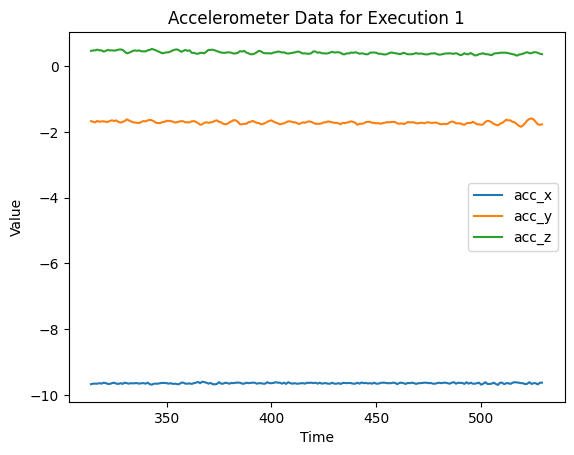

In [81]:
acc = exec1_sample[['acc_x', 'acc_y', 'acc_z']]
plt.plot(acc)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(sample_information.columns)
plt.title("Accelerometer Data for Execution 1")
plt.show()

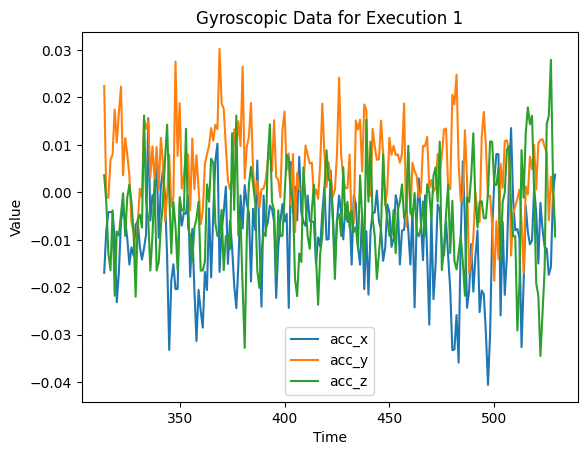

In [82]:
gyr = exec1_sample[['gyr_x', 'gyr_y', 'gyr_z']]
plt.plot(gyr)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(sample_information.columns)
plt.title("Gyroscopic Data for Execution 1")
plt.show()

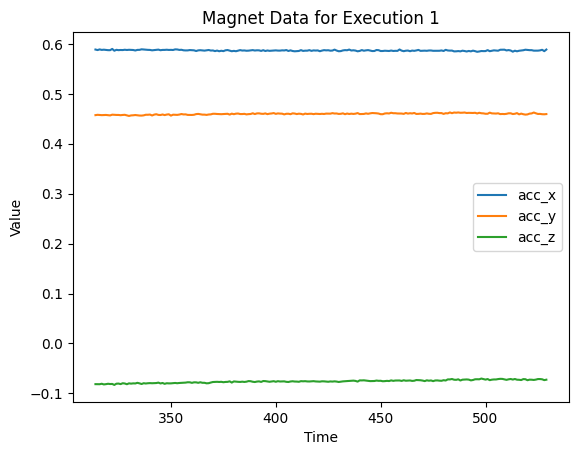

In [83]:
mag = exec1_sample[['mag_x', 'mag_y', 'mag_z']]
plt.plot(mag)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(sample_information.columns)
plt.title("Magnet Data for Execution 1")
plt.show()